In [1]:
import sys
sys.path.append('../')

We briefly show how the unlearning for the language models can be performed. Firstly, let us load a language model to verify that it has remembered the canary sentence.

In [3]:
from Unlearner.RNNUnlearner import RNNUNlearner
from Applications.CanaryRemoval.CanaryRemoval import get_params_by_model_name, load_data

CANARY_STR = "`my telephone number is {}!' said alice.\n\n  "
CANARY_START = "`my telephone number is "
canary_number = "0123456789"
n_layers = 2
n_units = 512

data_path = '../train_test_data/Alice/alice_in_wonderland.txt'
weight_path = '../models/LSTM/checkpoint_lambda=0.0001-canary_number=0123456789-canary_reps=6-embedding_dim=64-seqlen=24-dropout=0.0.ckpt'

lambda_, canary_number, canary_reps, embedding_dim, seq_length, p_dropout = get_params_by_model_name(weight_path)
canary = CANARY_STR.format(canary_number)

x_train, y_train, idx2char = load_data(data_path, seq_length, canary, canary_reps)

unlearner = RNNUNlearner(x_train, y_train, embedding_dim, idx2char, lambda_, weight_path, CANARY_START, canary_number,
                                 canary_reps, n_layers=n_layers, n_units=n_units,p_dropout=p_dropout)
# unlearner.generate_data(start_str=CANARY_START)

canary_exposure = unlearner.approx_exposure([canary_seq_perplexity], perplexity_distribution, only_digits=False)

Model parameters: [['checkpoint_lambda', '0.0001'], ['canary_number', '0123456789'], ['canary_reps', '6'], ['embedding_dim', '64'], ['seqlen', '24'], ['dropout', '0.0']]
Lambda: 0.0001
Canary number: 0123456789, Canary repetitions: 6
init RNNUnlearner with 148597 samples
x_train shape: (148597, 24, 1), y_train shape: (148597, 54)
Number of words in vocabulary: 54
 idx2char: {0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: '*', 8: ',', 9: '-', 10: '.', 11: '0', 12: '1', 13: '2', 14: '3', 15: '4', 16: '5', 17: '6', 18: '7', 19: '8', 20: '9', 21: ':', 22: ';', 23: '?', 24: '[', 25: ']', 26: '_', 27: '`', 28: 'a', 29: 'b', 30: 'c', 31: 'd', 32: 'e', 33: 'f', 34: 'g', 35: 'h', 36: 'i', 37: 'j', 38: 'k', 39: 'l', 40: 'm', 41: 'n', 42: 'o', 43: 'p', 44: 'q', 45: 'r', 46: 's', 47: 't', 48: 'u', 49: 'v', 50: 'w', 51: 'x', 52: 'y', 53: 'z'}
Number of words in vocabulary: 54
n_units: 512, n_layers: 2, p_dropout: 0.0


In [ ]:
from Unlearner.RNNUnlearner import RNNUNlearner
from Applications.CanaryRemoval.CanaryRemoval import get_params_by_model_name, load_data

CANARY_STR = "`my telephone number is {}!' said alice.\n\n  "
CANARY_START = "`my telephone number is "
canary_number = "0123456789"
n_layers = 2
n_units = 512

data_path = '../train_test_data/Alice/alice_in_wonderland.txt'
weight_path = '../models/LSTM/checkpoint_lambda=0.0001-canary_number=0123456789-canary_reps=6-embedding_dim=64-seqlen=24-dropout=0.0.ckpt'

lambda_, canary_number, canary_reps, embedding_dim, seq_length, p_dropout = get_params_by_model_name(weight_path)
canary = CANARY_STR.format(canary_number)

x_train, y_train, idx2char = load_data(data_path, seq_length, canary, canary_reps)

unlearner = RNNUNlearner(x_train, y_train, embedding_dim, idx2char, lambda_, weight_path, CANARY_START, canary_number,
                                 canary_reps, n_layers=n_layers, n_units=n_units,p_dropout=p_dropout)
# unlearner.generate_data(start_str=CANARY_START)
canary_seq_perplexity = unlearner.calc_sequence_perplexity(canary_number)

n_samples = 100000

perplexity_distribution = unlearner.calc_perplexity_distribution(no_samples=n_samples, plot=True, only_digits=False)

from Applications.CanaryRemoval.CanaryRemoval import unlearn_canary

replacement_strs = ['not there ', 'dry enough']

# first order params
taus = [0.0003, 0.0009]
batch_size_fo = 64

# second order params
batch_size_so = 500
damping = 0.1
iterations = 30
scales = [39000, 36000]

#Let's perform the unlearning for the different replacements and orders

### First Order - Replacement "not there "
res = unlearn_canary(unlearner, data_path, seq_length, canary_reps, tau=taus[0], order=1, batch_size=batch_size_fo,
                     scale=1, damping=0.0, iterations=1, replace_char=replacement_strs[0])
res = unlearn_canary(unlearner, data_path, seq_length, canary_reps, tau=1.0, order=2, batch_size=500,
                     scale=scales[0], damping=0.1, iterations=30, replace_char=replacement_strs[0])

### Result
We see that the model predicts the canary sequence and reveals the telephone number. Next let us quantify how strong the number is memorized by computing the log perplexity of the sequence.

In [6]:
canary_seq_perplexity = unlearner.calc_sequence_perplexity(canary_number)

Seed: `my telephone number is 
Prediction: 0123456689
Digit probas: [0.52450073 0.76724172 0.79482096 0.66451401 0.18042473 0.39829949
 0.65678751 0.10415474 0.31055996 0.39406475]
Canary perplexities at all points:
1: 0.9309833205950717
2: 1.3132302509326832
3: 1.6445284199545638
4: 2.2341569090247027
5: 4.704687868513865
6: 6.032762347486208
7: 6.639263740152726
8: 9.902463396381233
9: 11.589519662194036
10: 12.93301503867908


### Result

We see that the log perplexity of the canary number is about 13. What does this mean in terms of memorization? To answer this questions we have to consider the sequence in comparison to all possible sequences that exist. To this end, let us randomly sample 100,000 random characters for each digit number, compute the perplexity of the final strings and create a histogram over all perplexity values.

100/100 [==============================] - 114s 1s/step
Skewnorm-fit parameters: 0.930 - 118.609 - 19.113


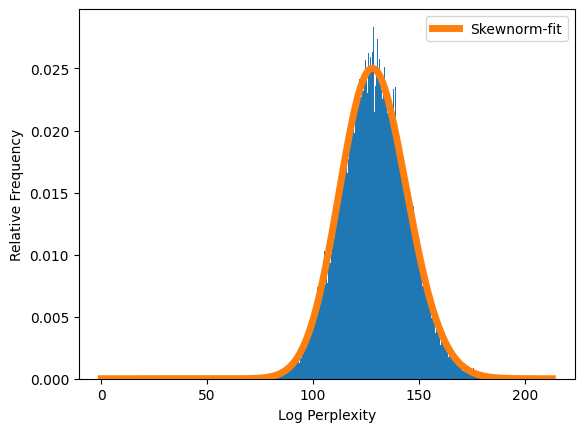

In [8]:
n_samples = 100000

perplexity_distribution = unlearner.calc_perplexity_distribution(no_samples=n_samples, plot=True, only_digits=False)

### Result

We see that the canary number is an extreme outlier in the distribution of perplexity values indicating a strong memorization. To quantify the memorization further, [Carlini et al](https://arxiv.org/pdf/1802.08232.pdf) propose the *exposure* metric that builds on the perplexity distribution and can be computed using the skewnorm-distribution fit above. We see that the exposure is very high and allows easy extraction of the canary number.

In [9]:
canary_exposure = unlearner.approx_exposure([canary_seq_perplexity], perplexity_distribution, only_digits=False)

Results for 12.93301503867908
2.361214973680345e-13% of all sequences are more likely than the given one.
Log(|R|) is 57.548875021634686
The exposure of the sequence is 48.58939202751096


Now let's remove the memorized sentence by the first order and second order method proposed in the paper. We have to find a replacement string (with 10 characters like the telephone number) and some hyperparameters for the methods.

In [10]:
from Applications.CanaryRemoval.CanaryRemoval import unlearn_canary

replacement_strs = ['not there ', 'dry enough']

# first order params
taus = [0.0003, 0.0009]
batch_size_fo = 64

# second order params
batch_size_so = 500
damping = 0.1
iterations = 30
scales = [39000, 36000]

Let's perform the unlearning for the different replacements and orders

### First Order - Replacement "not there "

In [11]:
res = unlearn_canary(unlearner, data_path, seq_length, canary_reps, tau=taus[0], order=1, batch_size=batch_size_fo,
                     scale=1, damping=0.0, iterations=1, replace_char=replacement_strs[0])

198 of 148597 samples are affected by the unlearning (0.1332462970315686%)
Unlearning took 1.8120503425598145 seconds.
Seed: `my telephone number is 
Prediction: it,' said alice.

  `then i'll go that you think you can find it,' said alice.


Train loss: [1.0734935998916626, 0.847325325012207]
Train acc: 0.847325316123475
Digit probas: [6.92400113e-02 4.26405761e-03 5.80643828e-04 9.24447249e-06
 9.15625890e-07 8.88020732e-05 1.49318197e-07 1.04327729e-08
 1.34923698e-06 1.09519522e-06]
Replacement_char proba: [2.50300718e-03 4.77796420e-03 6.37723133e-05 2.76839774e-06
 5.99318810e-06 2.34839135e-05 4.92285004e-08 6.94914561e-08
 2.36756023e-06 4.76878037e-10]
Canary perplexities at all points:
1: 3.8522502301464616
2: 11.725807583573651
3: 22.475866491022558
4: 39.198844061079754
5: 59.25758246890548
6: 72.71662958557805
7: 95.39173625709823
8: 121.90603836159947
9: 141.4054631635934
10: 161.2058436827466


### First Order - Replacement "dry enough"

In [12]:
res = unlearn_canary(unlearner, data_path, seq_length, canary_reps, tau=taus[1], order=1, batch_size=batch_size_fo,
                     scale=1, damping=0.0, iterations=1, replace_char=replacement_strs[1])

198 of 148597 samples are affected by the unlearning (0.1332462970315686%)
Unlearning took 1.1068053245544434 seconds.
Seed: `my telephone number is 
Prediction: turn one simple sere.

  this time the queen leps the tarts seet--and yes, and i
Train loss: [1.6663442850112915, 0.6707268357276917]
Train acc: 0.6707268652799182
Digit probas: [1.89163233e-03 4.14034905e-04 7.72634870e-04 2.81877612e-04
 5.04799536e-05 5.25701507e-05 9.49945661e-06 1.46815482e-05
 3.36506127e-05 4.75314038e-04]
Replacement_char proba: [1.06046768e-03 8.25777590e-07 3.68986279e-04 1.39544264e-03
 1.45042131e-05 1.43261132e-04 2.18742480e-06 5.91811477e-05
 4.44757188e-06 6.88689834e-05]
Canary perplexities at all points:
1: 9.046152579185904
2: 20.284112561336805
3: 30.622038150478538
4: 42.41468163297849
5: 56.68861152195893
6: 70.90400812500033
7: 87.58773170391311
8: 103.64336806332793
9: 118.50237576241513
10: 129.54120712987952


### Second Order - Replacement "not there "

In [13]:
res = unlearn_canary(unlearner, data_path, seq_length, canary_reps, tau=1.0, order=2, batch_size=500,
                     scale=scales[0], damping=0.1, iterations=30, replace_char=replacement_strs[0])

198 of 148597 samples are affected by the unlearning (0.1332462970315686%)
Early stopping at iteration 28. Update norm 136530.55548858643 > [126271.3204164505, 5]
Unlearning took 118.9620897769928 seconds.
Seed: `my telephone number is 
Prediction: it,' said alice.

  `that's the beginning with the little golden key
instaidly m
Train loss: [1.0105828046798706, 0.8726152181625366]
Train acc: 0.8726151941156282
Digit probas: [1.74378544e-01 8.29871837e-03 7.15415401e-04 6.86351996e-06
 1.09342761e-06 1.92892461e-04 1.35041375e-07 1.36605163e-08
 1.03148545e-06 1.43702823e-06]
Replacement_char proba: [3.45217669e-03 1.14413965e-02 5.46025367e-05 1.52926168e-06
 5.30614352e-06 2.28618610e-05 1.96928180e-08 7.03590075e-08
 9.81628318e-07 5.62379421e-10]
Canary perplexities at all points:
1: 2.519705556126178
2: 9.432601292677816
3: 19.881532496318375
4: 37.0341524131735
5: 56.83686326767216
6: 69.17677888746111
7: 91.99687404838913
8: 118.12228679886323
9: 138.00913189239975
10: 157.4176120

### Second Order - Replacement "dry enough"

In [14]:
res = unlearn_canary(unlearner, data_path, seq_length, canary_reps, tau=1.0, order=2, batch_size=batch_size_so,
                     scale=scales[1], damping=0.1, iterations=iterations, replace_char=replacement_strs[1])

198 of 148597 samples are affected by the unlearning (0.1332462970315686%)
Unlearning took 149.28084254264832 seconds.
Seed: `my telephone number is 
Prediction: the same with the next verse,' said alice in a
sorrowful tone,
          and pou
Train loss: [1.0123497247695923, 0.8724132776260376]
Train acc: 0.8724133057867924
Digit probas: [1.29172191e-01 7.39878160e-04 1.06637593e-07 1.49654525e-05
 1.29265172e-04 6.51663358e-05 1.87927083e-06 4.62215894e-06
 3.46199090e-06 2.82270757e-05]
Replacement_char proba: [2.04231337e-01 9.67936103e-07 6.28215702e-10 8.15702705e-09
 1.83054406e-04 2.90269355e-07 1.96646088e-05 2.80454537e-06
 3.04502435e-04 5.75833432e-02]
Canary perplexities at all points:
1: 2.952632583604231
2: 13.353057249860266
3: 36.513837792651785
4: 52.54184236921577
5: 65.45922112428855
6: 79.36473472097757
7: 98.38613029844129
8: 116.10913199782115
9: 134.24909863455107
10: 149.36165943207308


### Results

We see that the perplexity is increased greatly through the unlearning steps. Considering the distribution above the canary number is now clearly right of the mean of the distribution and very unlikely to be predicted. Furthermore, we notice that already the first order update can remove the memorization and different replacements yield different perplexity values after unlearning.